# Toronto Bike Sharing Data Analysis - January 2024

## Table of Contents

1. [Dataset Overview](#1)
2. [Data Cleaning and Preprocessing](#2)
3. [Feature Engineering](#3)
4. [Data Analysis and Visualization](#4)
5. [Spatial Analysis and Trip Characteristics](#5)
6. [Station Usage Analysis and Geospatial Visualization](#6)
7. [Station Pair Analysis and Trip Patterns](#7)

## Dataset Overview <a id="1"></a>

The original dataset contains information about bike sharing trips in Toronto for January 2024. It includes details such as trip duration, start and end station information, bike IDs, and user types. However, it was observed that the dataset lacked complete station names and geographical coordinates (latitude and longitude) for each station.

### Data Enrichment

To address the missing information, a supplementary dataset was obtained from a JSON file available on the web. The process of fetching and processing this additional data is described below:

1. The JSON data was fetched from the following URL:
   https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information

2. A GET request was sent to the URL, and the response was checked for success.

3. Upon successful retrieval, the JSON content was parsed, and the list of stations was extracted.

4. The stations data was converted into a pandas DataFrame.

5. The resulting DataFrame was saved as a CSV file named "stations.csv".

### Enriched Dataset Structure

The enriched stations dataset includes the following columns:

- station_id: Unique identifier for each station (int64)
- name: Full name of the station (object)
- physical_configuration: Configuration details of the station (object)
- lat: Latitude coordinate of the station (float64)
- lon: Longitude coordinate of the station (float64)
- altitude: Altitude of the station location (float64, with some null values)
- address: Street address of the station (object)
- capacity: Number of bikes the station can hold (int64)
- is_charging_station: Boolean indicating if the station has charging capabilities (bool)
- rental_methods: Available methods for renting bikes (object)
- groups: Grouping information for the station (object)
- obcn: Additional identifier (object, with some null values)
- short_name: Abbreviated name of the station (object, with some null values)
- nearby_distance: Distance to nearby points of interest (float64)
- *ride*code_support: Boolean indicating support for ride codes (bool)
- rental_uris: URIs related to the rental process (object)
- post_code: Postal code of the station location (object, with some null values)
- is_valet_station: Indicates if the station has valet service (object, with many null values)
- cross_street: Nearest cross street to the station (object, with many null values)

### Original Dataset Structure

The original Toronto bike sharing dataset for January 2024 (https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/)  contains the following columns:

- Trip Id: Unique identifier for each trip (int64)
- Trip Duration: Duration of the trip in seconds (int64)
- Start Station Id: Identifier of the starting station (int64)
- Start Time: Timestamp of when the trip began (object)
- Start Station Name: Name of the starting station (object, with some null values)
- End Station Id: Identifier of the ending station (float64)
- End Time: Timestamp of when the trip ended (object)
- End Station Name: Name of the ending station (object, with some null values)
- Bike Id: Unique identifier for the bike used (int64)
- User Type: Category of the user who made the trip (object)

By combining these two datasets, a more comprehensive analysis of the Toronto bike sharing system for January 2024 can be conducted, including geographical insights and complete station information.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import folium
from math import radians, sin, cos, sqrt, atan2
from datetime import datetime
from folium.plugins import HeatMap
from scipy.spatial.distance import pdist, squareform
from folium.plugins import MarkerCluster
from IPython.display import display


In [3]:
# Step 1: Fetch the JSON data from the webpage or API
url = "https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information"  # Replace with the actual URL containing the JSON data
response = requests.get(url)

# Step 2: Check if the request was successful
if response.status_code == 200:
    data = response.json()  # Parse the JSON content
    stations = data["data"]["stations"]  # Extract the list of stations

    # Step 3: Convert the stations data to a pandas DataFrame
    df = pd.DataFrame(stations)

    # Step 4: Save the DataFrame as a CSV file
    df.to_csv("stations.csv", index=False)

    print("CSV file saved successfully!")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")


CSV file saved successfully!


In [2]:
stations_df = pd.read_csv('stations.csv')


In [3]:
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852 entries, 0 to 851
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   station_id              852 non-null    int64  
 1   name                    852 non-null    object 
 2   physical_configuration  852 non-null    object 
 3   lat                     852 non-null    float64
 4   lon                     852 non-null    float64
 5   altitude                446 non-null    float64
 6   address                 851 non-null    object 
 7   capacity                852 non-null    int64  
 8   is_charging_station     852 non-null    bool   
 9   rental_methods          852 non-null    object 
 10  groups                  852 non-null    object 
 11  obcn                    737 non-null    object 
 12  short_name              737 non-null    object 
 13  nearby_distance         852 non-null    float64
 14  _ride_code_support      852 non-null    bo

In [4]:
trips_df = pd.read_csv('Bike share ridership 2024-01.csv')

In [5]:
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204870 entries, 0 to 204869
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Trip Id             204870 non-null  int64  
 1   Trip  Duration      204870 non-null  int64  
 2   Start Station Id    204870 non-null  int64  
 3   Start Time          204870 non-null  object 
 4   Start Station Name  176657 non-null  object 
 5   End Station Id      204775 non-null  float64
 6   End Time            204870 non-null  object 
 7   End Station Name    176642 non-null  object 
 8   Bike Id             204870 non-null  int64  
 9   User Type           204870 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 15.6+ MB


## Data Cleaning and Preprocessing <a id="2"></a>

The original dataset underwent several cleaning and preprocessing steps to ensure data quality and completeness. The following operations were performed:

1. The initial number of rows in the dataset was recorded.

2. Rows with a trip duration of 0 seconds were removed, as these likely represent data errors or canceled trips.

3. Trips where the start and end station IDs were identical were eliminated, as these may not represent actual journeys.

4. Start station data was merged with the main dataset, bringing in latitude, longitude, and full station names.

5. End station data was similarly merged, adding geographical coordinates and complete station names for trip destinations.

6. Missing station names in the original dataset were filled with the more complete information from the stations dataset.

7. Unnecessary columns resulting from the merge operations were removed to streamline the dataset.

8. Duplicate latitude and longitude columns were eliminated to avoid redundancy.

9. Any remaining rows with null values were dropped to ensure a complete dataset for analysis.

10. The dataset's index was reset after all row removals to maintain continuity.

11. A final check was performed to confirm the absence of null values and to verify that all remaining trips had different start and end stations.

These preprocessing steps resulted in a clean, consistent dataset ready for further analysis. The number of rows in the final dataset was recorded to quantify the impact of the cleaning process.

The structure and content of the cleaned dataset were then displayed, showing the first few rows and providing a summary of the DataFrame's information. This allows for a quick verification of the data types and non-null counts for each column.

By ensuring data quality and completeness, subsequent analyses can be conducted with greater confidence in the reliability of the results.

In [6]:
# Print original number of rows
print(f"Original number of rows: {len(trips_df)}")

# Drop rows where trip duration is 0
trips_df = trips_df[trips_df['Trip  Duration'] > 0].reset_index(drop=True)

# Drop rows where start and end station IDs are the same
trips_df = trips_df[trips_df['Start Station Id'] != trips_df['End Station Id']].reset_index(drop=True)

# Merge start station data
trips_df = pd.merge(
    trips_df,
    stations_df[['station_id', 'lat', 'lon', 'name']],
    left_on='Start Station Id',
    right_on='station_id',
    how='left',
    suffixes=('', '_start')
)

# Rename columns
trips_df = trips_df.rename(columns={
    'lat': 'lat_start',
    'lon': 'lon_start',
    'name': 'start_station_name'
})

# Merge end station data
trips_df = pd.merge(
    trips_df,
    stations_df[['station_id', 'lat', 'lon', 'name']],
    left_on='End Station Id',
    right_on='station_id',
    how='left',
    suffixes=('', '_end')
)

# Rename columns
trips_df = trips_df.rename(columns={
    'lat': 'lat_end',
    'lon': 'lon_end',
    'name': 'end_station_name'
})

# Fill missing station names
trips_df['Start Station Name'] = trips_df['Start Station Name'].fillna(trips_df['start_station_name'])
trips_df['End Station Name'] = trips_df['End Station Name'].fillna(trips_df['end_station_name'])

# Drop unnecessary columns
trips_df = trips_df.drop(columns=['station_id', 'station_id_end', 'start_station_name', 'end_station_name'])

# Remove duplicate lat/lon columns
trips_df = trips_df.loc[:, ~trips_df.columns.duplicated()]

# Drop all rows with any null values
trips_df = trips_df.dropna()

# Reset index after dropping rows
trips_df = trips_df.reset_index(drop=True)

# Print number of rows after processing
print(f"Number of rows after processing: {len(trips_df)}")

# Display the first few rows and info of the updated DataFrame
print(trips_df.head())
print(trips_df.info())

# Check for any remaining null values
print("\nNull values in each column:")
print(trips_df.isnull().sum())

# Check for any remaining trips with different start and end station
different_station_trips = trips_df[trips_df['Start Station Id'] != trips_df['End Station Id']]
print(f"\nNumber of trips with different start and end station: {len(different_station_trips)}")

Original number of rows: 204870
Number of rows after processing: 191192
    Trip Id  Trip  Duration  Start Station Id        Start Time  \
0  26682740             528              7041  01/01/2024 00:00   
1  26682742            1924              7245  01/01/2024 00:02   
2  26682743            2741              7052  01/01/2024 00:03   
3  26682744             353              7041  01/01/2024 00:03   
4  26682748            3014              7788  01/01/2024 00:05   

                  Start Station Name  End Station Id          End Time  \
0               Edward St / Yonge St          7130.0  01/01/2024 00:08   
1  Tecumseth St / Queen St W - SMART          7259.0  01/01/2024 00:34   
2           Wellington St W / Bay St          7366.0  01/01/2024 00:49   
3               Edward St / Yonge St          7418.0  01/01/2024 00:09   
4   Queens Quay E / Lower Jarvis St           7686.0  01/01/2024 00:55   

                      End Station Name  Bike Id      User Type  lat_start  \
0  

In [7]:
trips_df.to_csv('Rideshare_Toronto.csv')

In [8]:
df = pd.read_csv('Rideshare_Toronto.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191192 entries, 0 to 191191
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          191192 non-null  int64  
 1   Trip Id             191192 non-null  int64  
 2   Trip  Duration      191192 non-null  int64  
 3   Start Station Id    191192 non-null  int64  
 4   Start Time          191192 non-null  object 
 5   Start Station Name  191192 non-null  object 
 6   End Station Id      191192 non-null  float64
 7   End Time            191192 non-null  object 
 8   End Station Name    191192 non-null  object 
 9   Bike Id             191192 non-null  int64  
 10  User Type           191192 non-null  object 
 11  lat_start           191192 non-null  float64
 12  lon_start           191192 non-null  float64
 13  lat_end             191192 non-null  float64
 14  lon_end             191192 non-null  float64
dtypes: float64(5), int64(5), object(5)

## Feature Engineering <a id="3"></a>

To enhance the dataset for more comprehensive analysis, several new features were engineered and added:

### Temporal Features

1. The 'Start Time' and 'End Time' columns were converted to datetime format for easier manipulation.

2. Trip duration was recalculated in minutes for more intuitive analysis:
   - A new column 'Trip Duration (min)' was created by subtracting 'Start Time' from 'End Time' and converting to minutes.

3. Additional temporal features were extracted from the 'Start Time':
   - 'Hour': The hour when the trip started
   - 'Day of Week': The name of the day when the trip started
   - 'Month': The name of the month when the trip started
   - 'Date': The date of the trip start

### Spatial Features

1. Trip distance was calculated using the Haversine formula:
   - A function `haversine_distance()` was defined to compute the great-circle distance between two points on a sphere given their latitudes and longitudes.
   - The distance between start and end stations was calculated for each trip and stored in a new 'Distance (km)' column.

2. Trip speed was computed:
   - A new column 'Speed (km/h)' was added, calculated by dividing the trip distance by the duration in hours.

### Trip Identification

1. A 'Station Pair' column was created by concatenating the start and end station names:
   - This allows for easy identification and analysis of specific routes.

These new features provide additional dimensions for analyzing the bike-sharing data, enabling insights into temporal patterns, spatial characteristics, and popular routes within the system.

In [10]:

# Convert Start Time and End Time to datetime
df['Start Time'] = pd.to_datetime(df['Start Time'])
df['End Time'] = pd.to_datetime(df['End Time'])

# Calculate trip duration in minutes
df['Trip Duration (min)'] = (df['End Time'] - df['Start Time']).dt.total_seconds() / 60

# temporal Analysis
df['Hour'] = df['Start Time'].dt.hour
df['Day of Week'] = df['Start Time'].dt.day_name()
df['Month'] = df['Start Time'].dt.month_name()
df['Date'] = df['Start Time'].dt.date

# Function to calculate distance using Haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in kilometers

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c

    return distance

# Calculate distance for each trip
df['Distance (km)'] = df.apply(lambda row: haversine_distance(
    row['lat_start'], row['lon_start'], row['lat_end'], row['lon_end']), axis=1)

# Calculate speed in km/h
df['Speed (km/h)'] = df['Distance (km)'] / (df['Trip Duration (min)'] / 60)

# Create a column for station pairs
df['Station Pair'] = df['Start Station Name'] + ' to ' + df['End Station Name']



In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191192 entries, 0 to 191191
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Unnamed: 0           191192 non-null  int64         
 1   Trip Id              191192 non-null  int64         
 2   Trip  Duration       191192 non-null  int64         
 3   Start Station Id     191192 non-null  int64         
 4   Start Time           191192 non-null  datetime64[ns]
 5   Start Station Name   191192 non-null  object        
 6   End Station Id       191192 non-null  float64       
 7   End Time             191192 non-null  datetime64[ns]
 8   End Station Name     191192 non-null  object        
 9   Bike Id              191192 non-null  int64         
 10  User Type            191192 non-null  object        
 11  lat_start            191192 non-null  float64       
 12  lon_start            191192 non-null  float64       
 13  lat_end       

In [12]:
df.to_csv('Rideshare_Toronto_FG.csv')

In [13]:
df = pd.read_csv('Rideshare_Toronto_FG.csv')

## Data Analysis and Visualization <a id="4"></a>

The Toronto bike-sharing dataset was analyzed using various statistical and visual methods to extract meaningful insights. The following analyses were performed:

### 1. Basic Information and Summary Statistics
- The dataset's structure, data types, and basic statistics were examined to understand its composition.

### 2. User Type Distribution
- A bar plot was created to visualize the proportion of different user types in the system.

### 3. Trip Duration Analysis
- A histogram with a kernel density estimate was used to show the distribution of trip durations, with the x-axis limited to the 99th percentile to handle outliers.

### 4. Temporal Patterns
- Bar plots were generated to display the number of trips by:
  - Hour of the day
  - Day of the week
  - Month

### 5. Popular Start Stations
- A bar chart of the top 10 most frequently used start stations was created.

### 6. Trip Duration by User Type
- A box plot was used to compare trip durations across different user types, with the y-axis limited to the 99th percentile.

### 7. Correlation Analysis
- A heatmap was generated to visualize the correlation between numeric variables in the dataset.

### 8. Trip Count Over Time
- A line plot was created to show the daily number of trips over the data collection period.

### 9. Average Trip Duration by Hour
- A line plot with markers was used to display how average trip duration varies by hour of the day.

### 10. Additional Insights
- Key statistics were calculated and printed, including:
  - Total number of trips
  - Number of unique bikes used
  - Date range of the data
  - Most common user type
  - Average and median trip durations
  - Busiest day, hour, and month

### 11. Geospatial Visualization
- A heatmap was created using Folium to visualize the spatial distribution of trip start locations across Toronto.

These analyses provide a comprehensive overview of the bike-sharing system's usage patterns, popular locations, and user behaviors, offering valuable insights for system optimization and decision-making.

1. Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191192 entries, 0 to 191191
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Unnamed: 0.1         191192 non-null  int64         
 1   Unnamed: 0           191192 non-null  int64         
 2   Trip Id              191192 non-null  int64         
 3   Trip  Duration       191192 non-null  int64         
 4   Start Station Id     191192 non-null  int64         
 5   Start Time           191192 non-null  datetime64[ns]
 6   Start Station Name   191192 non-null  object        
 7   End Station Id       191192 non-null  float64       
 8   End Time             191192 non-null  datetime64[ns]
 9   End Station Name     191192 non-null  object        
 10  Bike Id              191192 non-null  int64         
 11  User Type            191192 non-null  object        
 12  lat_start            191192 non-null  float64     

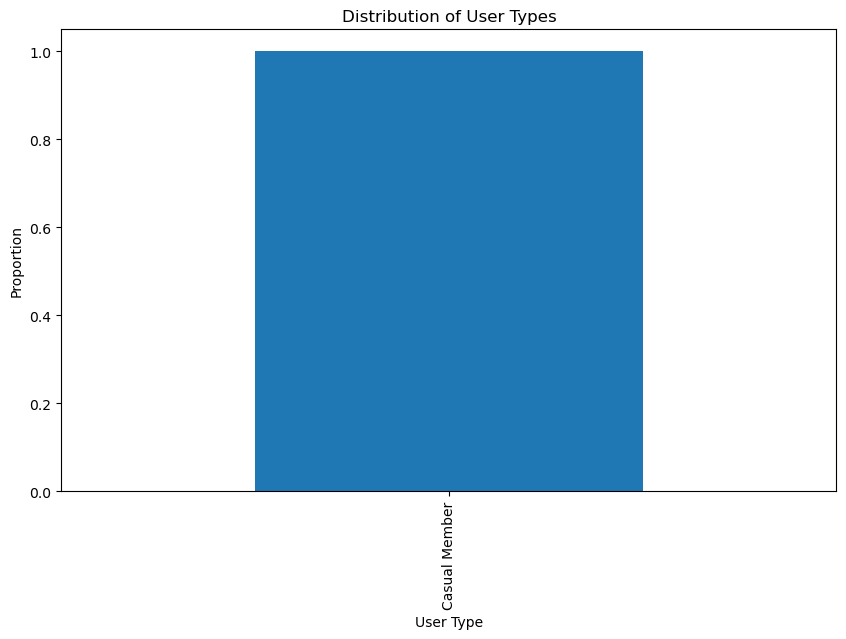

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


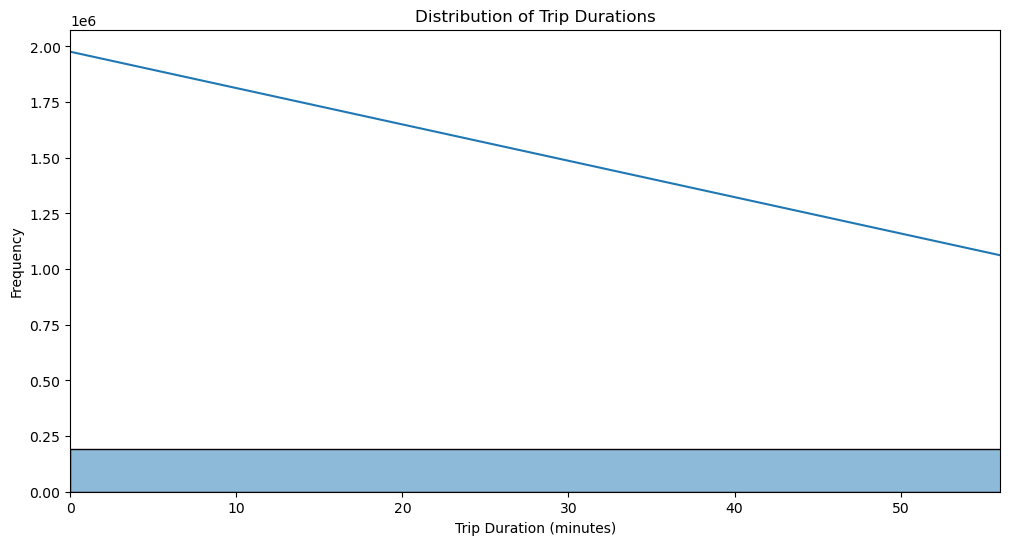

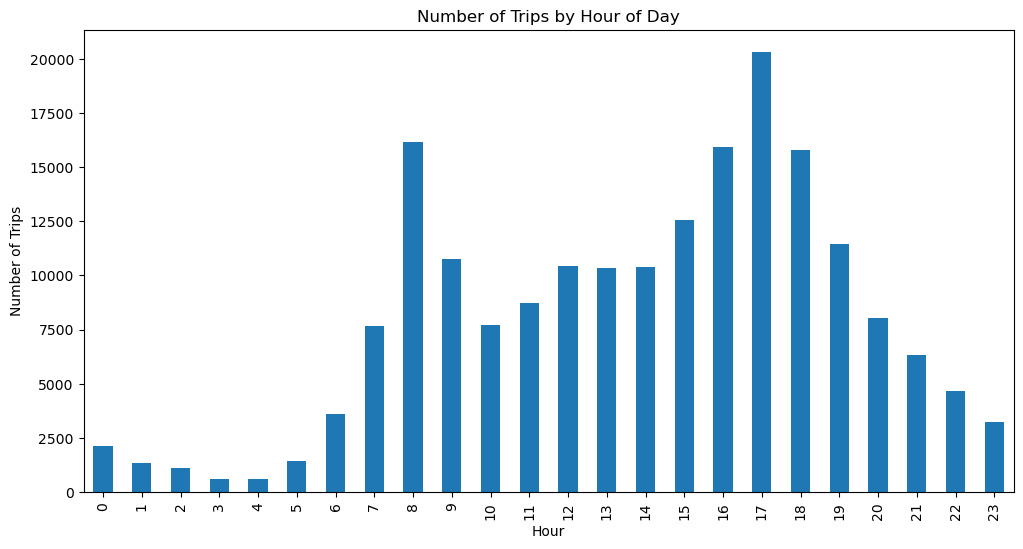

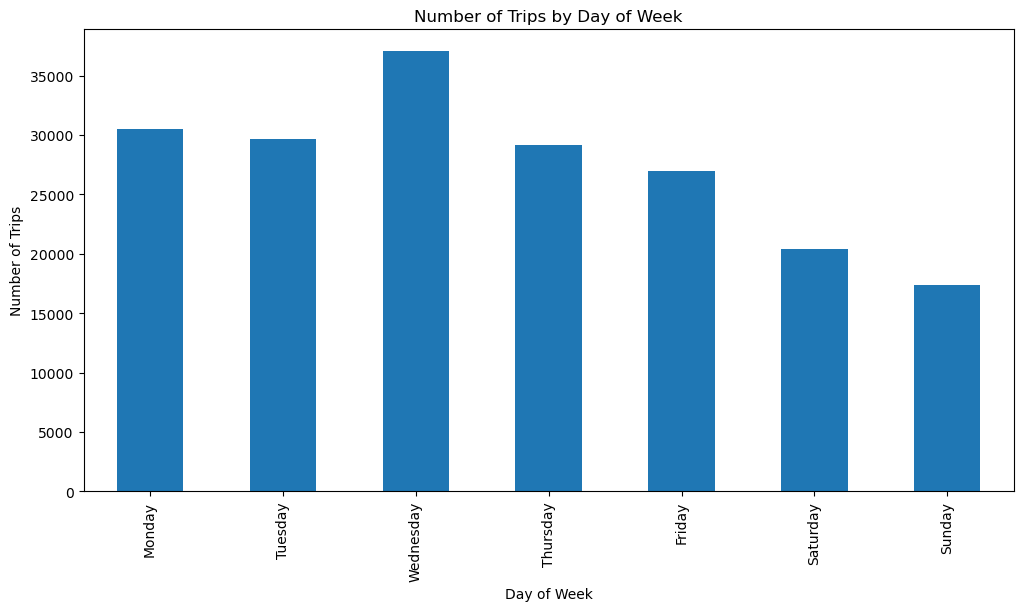

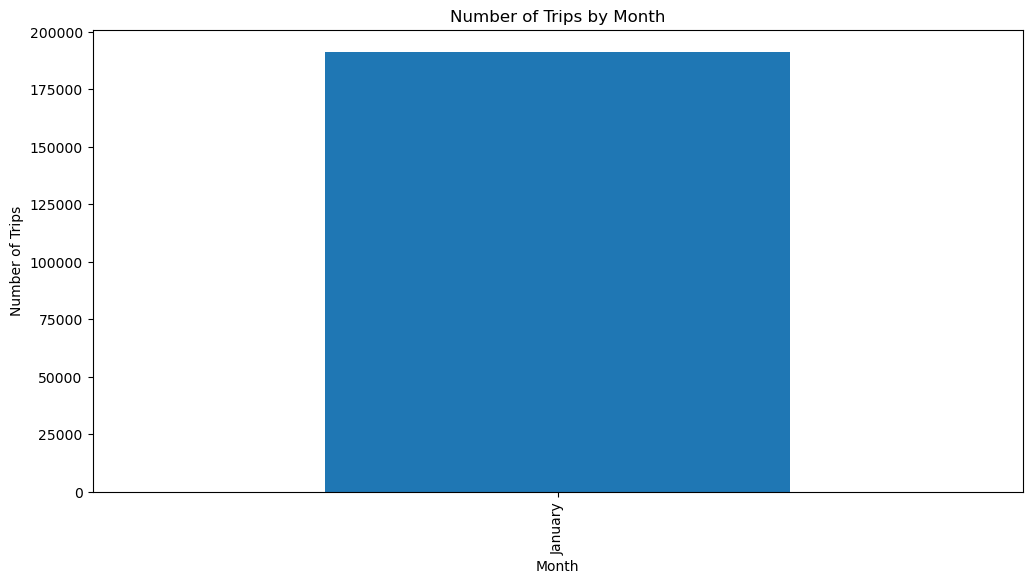

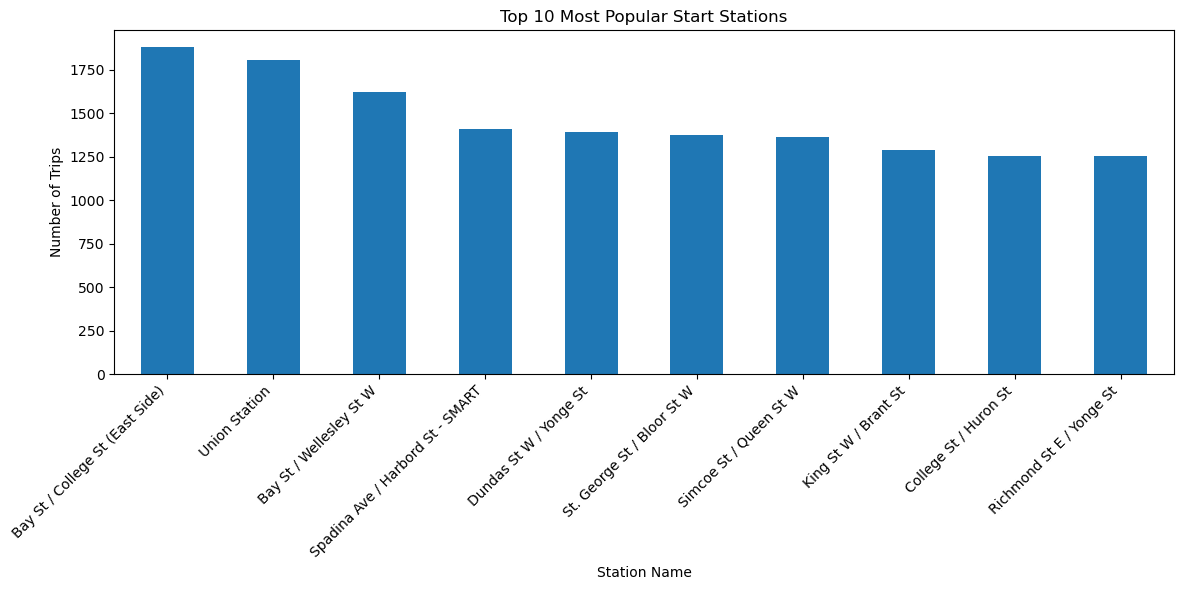

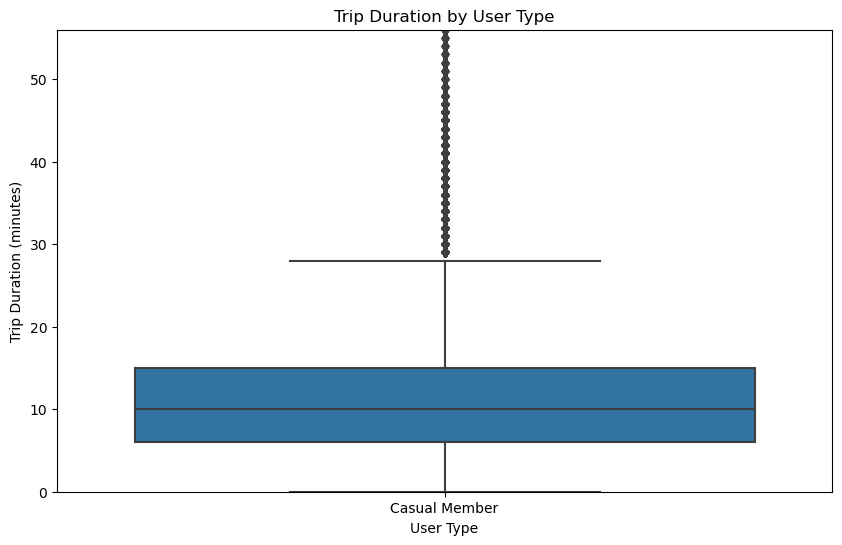

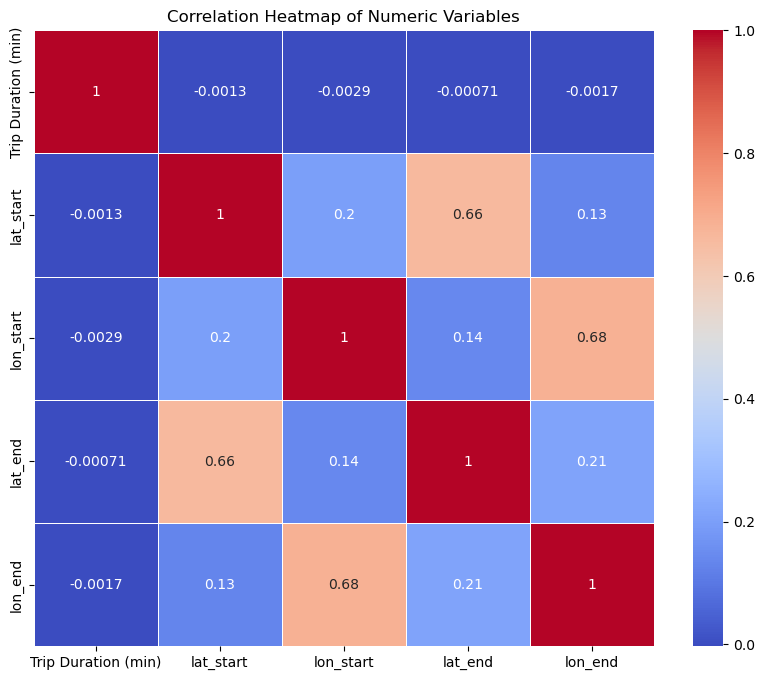

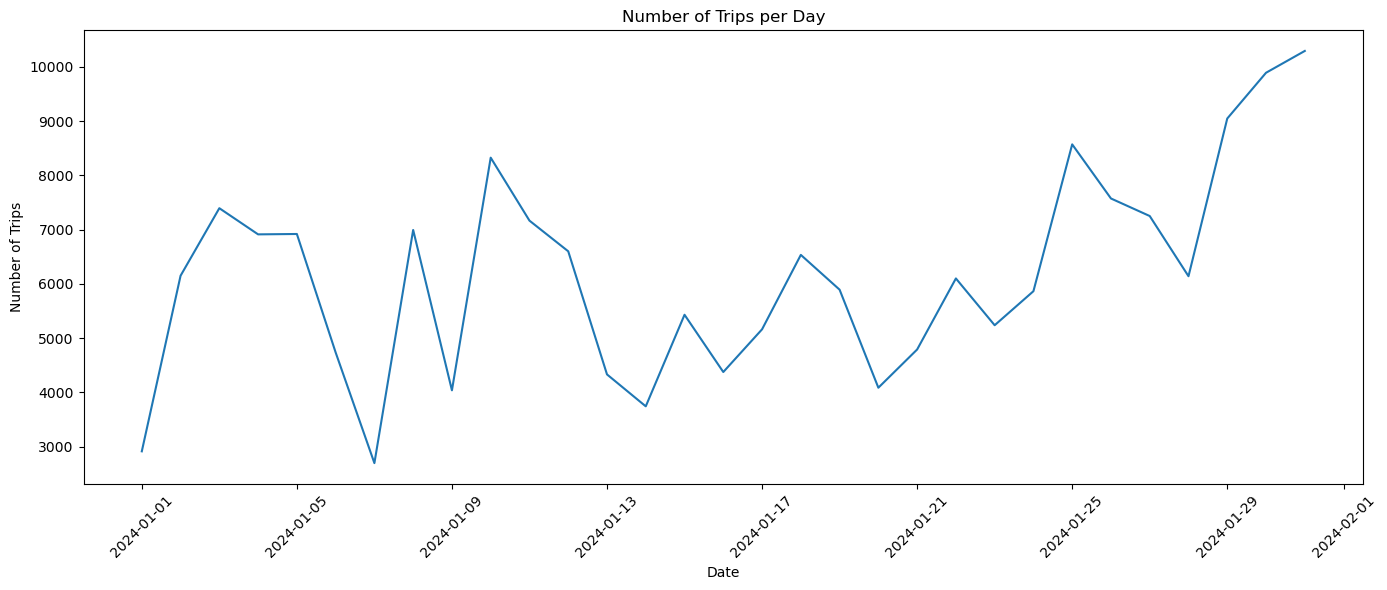

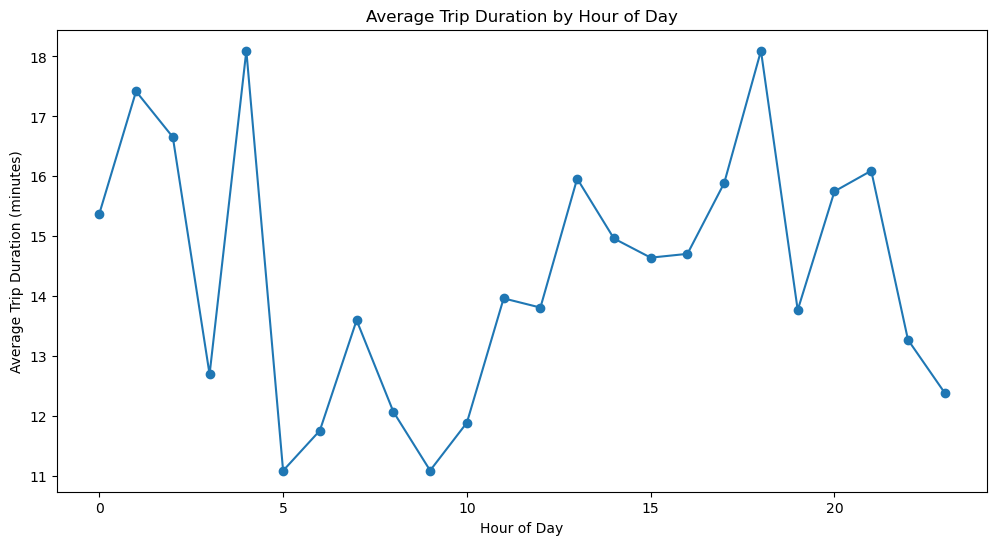


Additional Insights:
Total number of trips: 191192
Number of unique bikes used: 5763
Date range: from 2024-01-01 00:00:00 to 2024-01-31 23:59:00
Most common user type: Casual Member
Average trip duration: 14.44 minutes
Median trip duration: 10.00 minutes
Busiest day: Wednesday
Busiest hour: 17
Busiest month: January


In [14]:
# Convert Start Time and End Time to datetime
df['Start Time'] = pd.to_datetime(df['Start Time'])
df['End Time'] = pd.to_datetime(df['End Time'])

# temporal Analysis
df['Hour'] = df['Start Time'].dt.hour
df['Day of Week'] = df['Start Time'].dt.day_name()
df['Month'] = df['Start Time'].dt.month_name()
df['Date'] = df['Start Time'].dt.date


# 1. Basic Information
print("1. Basic Information:")
print(df.info())

# 2. Summary Statistics
print("\n2. Summary Statistics:")
print(df.describe())

# 3. User Type Distribution
plt.figure(figsize=(10, 6))
df['User Type'].value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of User Types')
plt.xlabel('User Type')
plt.ylabel('Proportion')
plt.show()

# 4. Trip Duration Analysis
plt.figure(figsize=(12, 6))
sns.histplot(df['Trip Duration (min)'], bins=50, kde=True)
plt.title('Distribution of Trip Durations')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')
plt.xlim(0, df['Trip Duration (min)'].quantile(0.99))  # Limit x-axis to 99th percentile
plt.show()


# Trips by Hour
plt.figure(figsize=(12, 6))
df['Hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Trips by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Trips')
plt.show()

# Trips by Day of Week
plt.figure(figsize=(12, 6))
df['Day of Week'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(kind='bar')
plt.title('Number of Trips by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Trips')
plt.show()

# Trips by Month
plt.figure(figsize=(12, 6))
df['Month'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Trips by Month')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.show()

# 6. Most Popular Start Stations
top_start_stations = df['Start Station Name'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_start_stations.plot(kind='bar')
plt.title('Top 10 Most Popular Start Stations')
plt.xlabel('Station Name')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 7. Trip Duration by User Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='User Type', y='Trip Duration (min)', data=df)
plt.title('Trip Duration by User Type')
plt.ylabel('Trip Duration (minutes)')
plt.ylim(0, df['Trip Duration (min)'].quantile(0.99))  # Limit y-axis to 99th percentile
plt.show()

# 8. Correlation Heatmap
numeric_cols = ['Trip Duration (min)', 'lat_start', 'lon_start', 'lat_end', 'lon_end']
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

# 9. Trip Count Over Time
df['Date'] = df['Start Time'].dt.date
daily_trips = df.groupby('Date').size().reset_index(name='Trip Count')
plt.figure(figsize=(14, 6))
plt.plot(daily_trips['Date'], daily_trips['Trip Count'])
plt.title('Number of Trips per Day')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 10. Average Trip Duration by Hour
hourly_duration = df.groupby('Hour')['Trip Duration (min)'].mean()
plt.figure(figsize=(12, 6))
hourly_duration.plot(kind='line', marker='o')
plt.title('Average Trip Duration by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Trip Duration (minutes)')
plt.show()

# Additional Insights
print("\nAdditional Insights:")
print(f"Total number of trips: {len(df)}")
print(f"Number of unique bikes used: {df['Bike Id'].nunique()}")
print(f"Date range: from {df['Start Time'].min()} to {df['Start Time'].max()}")
print(f"Most common user type: {df['User Type'].mode()[0]}")
print(f"Average trip duration: {df['Trip Duration (min)'].mean():.2f} minutes")
print(f"Median trip duration: {df['Trip Duration (min)'].median():.2f} minutes")
print(f"Busiest day: {df['Day of Week'].value_counts().index[0]}")
print(f"Busiest hour: {df['Hour'].value_counts().index[0]}")
print(f"Busiest month: {df['Month'].value_counts().index[0]}")

# Create a map centered on Toronto
toronto_map = folium.Map(location=[df['lat_start'].mean(), df['lon_start'].mean()], zoom_start=12)

# Add a heatmap layer
heat_data = df[['lat_start', 'lon_start']].values.tolist()
HeatMap(heat_data).add_to(toronto_map)

# Display the map in the notebook
toronto_map

## Spatial Analysis and Trip Characteristics <a id="5"></a>

To gain deeper insights into the spatial patterns and trip characteristics of the Toronto bike-sharing system, several analyses were conducted:

### 1. Trip Duration and Distance Calculation
- Trip durations were calculated in minutes.
- Trip speeds were computed in km/h using the distance and duration.

### 2. Distance Analysis
- Basic statistics of trip distances were calculated and displayed.
- A histogram was created to visualize the distribution of trip distances, with the x-axis limited to the 99th percentile to handle outliers.

### 3. Trip Duration vs Distance
- A scatter plot was generated to explore the relationship between trip duration and distance.
- The plot was limited to the 99th percentile for both axes to focus on the most representative data points.

### 4. Distance by User Type
- A box plot was used to compare trip distances across different user types, with the y-axis limited to the 99th percentile.

### 5. Speed Analysis
- A histogram was created to show the distribution of trip speeds, with the x-axis limited to the 99th percentile.
- Average speeds by hour of the day were plotted to identify temporal patterns in cycling speeds.

### 6. Route Analysis
- The top 10 longest routes were identified and visualized using a bar chart.

### 7. Spatial Heatmap
- A heatmap was generated to visualize the average trip distances between different station pairs.

### 8. Additional Insights
Key statistics were calculated and printed, including:
- Average and median trip distances
- Average and median speeds
- Correlation between distance and duration
- Longest trip distance
- Fastest recorded speed

These analyses provide valuable insights into the spatial patterns of bike usage, typical trip characteristics, and variations in usage across different user types and times of day. The findings can be used to optimize station placements, identify popular routes for infrastructure improvements, and tailor services to different user segments.

Trip Distance Statistics:
count    191192.000000
mean          1.706277
std           1.214110
min           0.003605
25%           0.879866
50%           1.392491
75%           2.169045
max          16.634496
Name: Distance (km), dtype: float64


C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


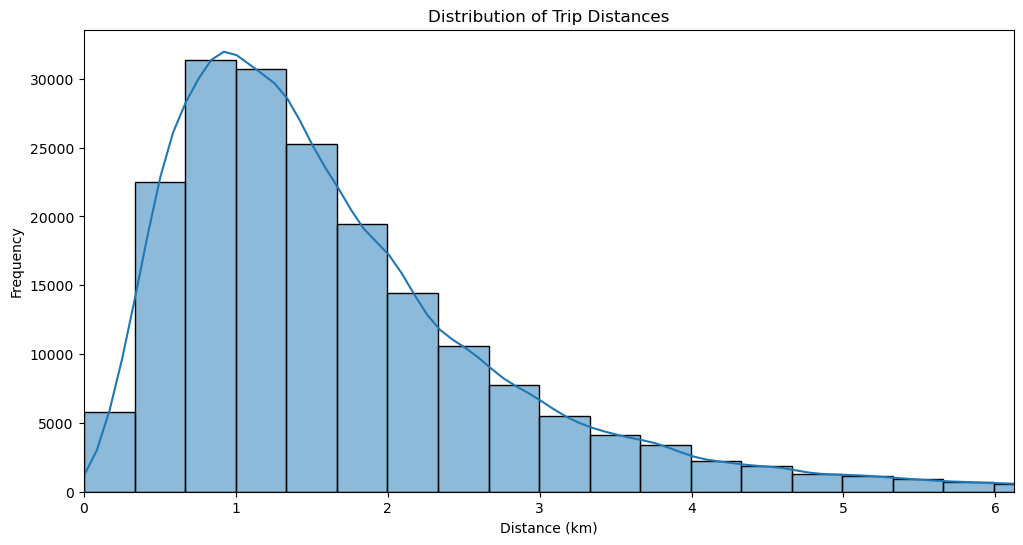

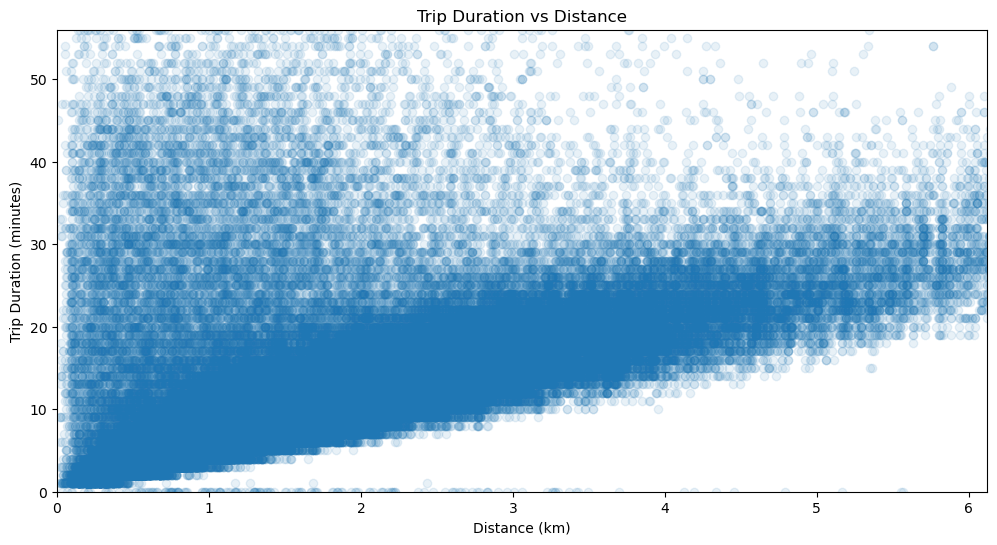

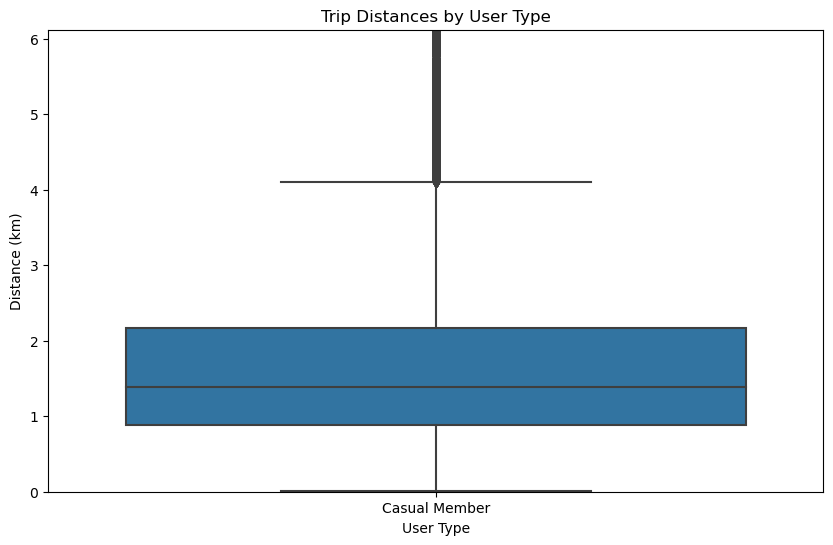

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


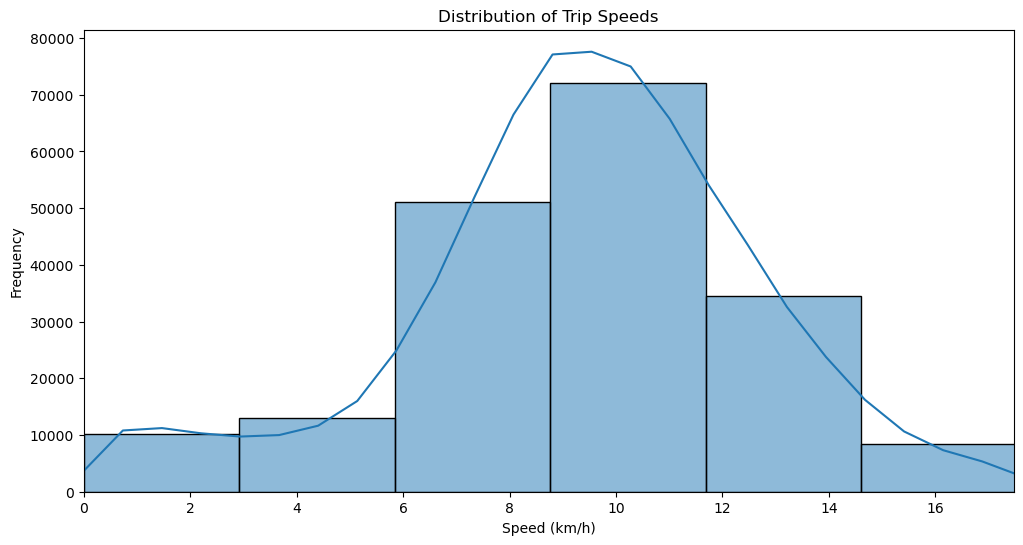

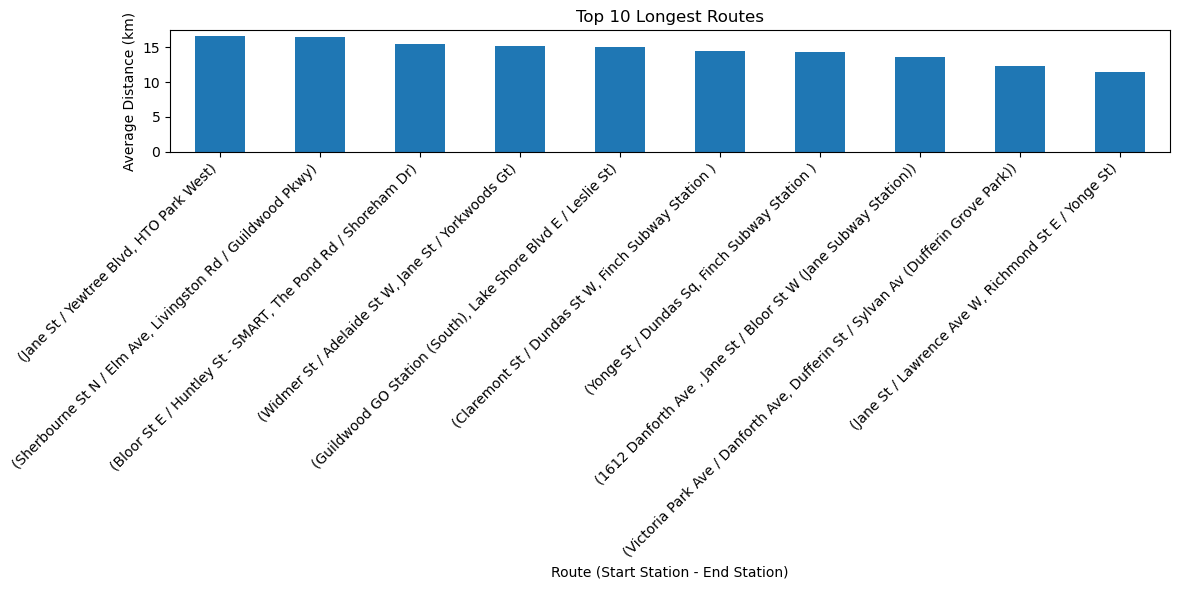


Additional Insights:
Average trip distance: 1.71 km
Median trip distance: 1.39 km
Average speed: inf km/h
Median speed: 9.55 km/h
Correlation between distance and duration: 0.05
Longest trip: 16.63 km
Fastest speed: inf km/h


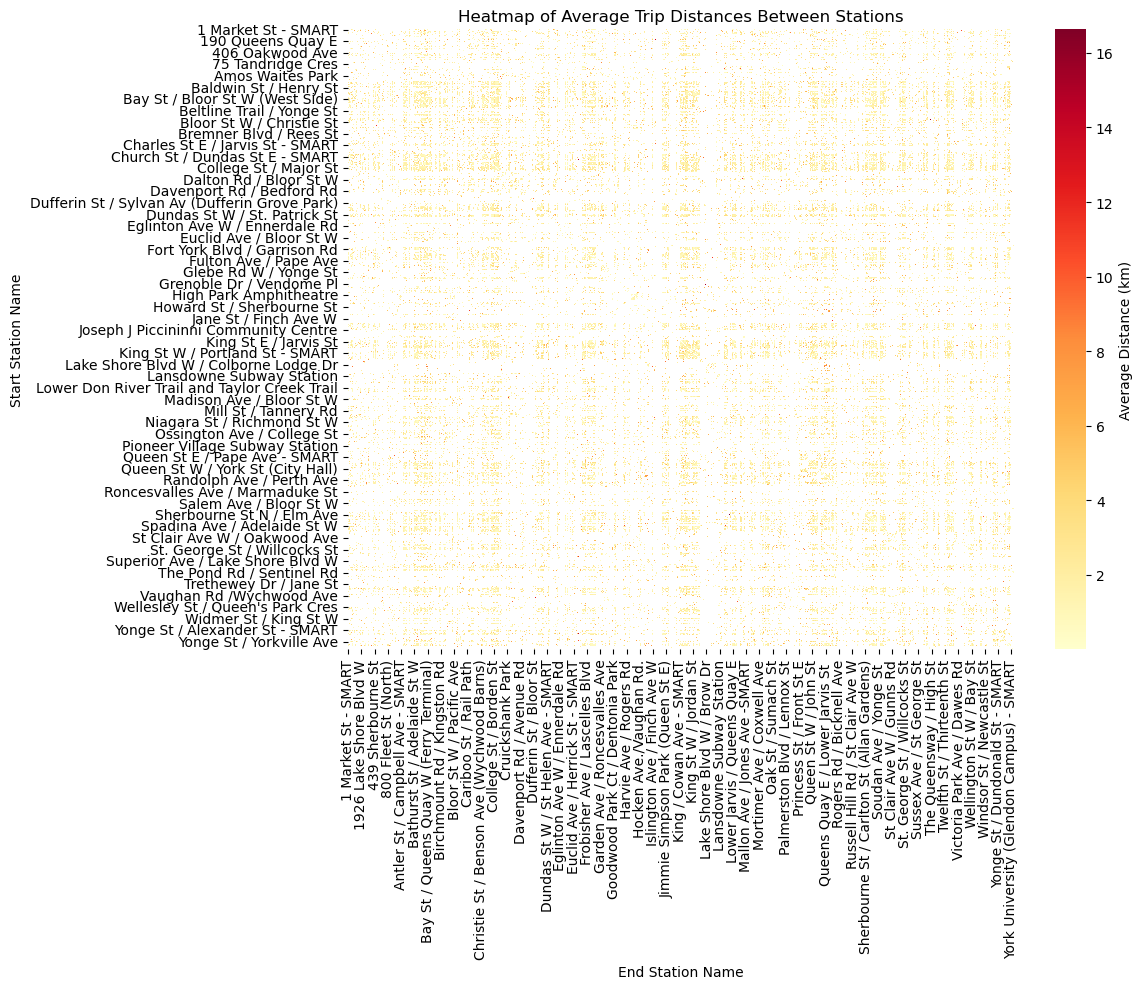

In [15]:
# Convert Start Time and End Time to datetime
df['Start Time'] = pd.to_datetime(df['Start Time'])
df['End Time'] = pd.to_datetime(df['End Time'])

# Calculate trip duration in minutes
df['Trip Duration (min)'] = (df['End Time'] - df['Start Time']).dt.total_seconds() / 60

# Calculate speed in km/h
df['Speed (km/h)'] = df['Distance (km)'] / (df['Trip Duration (min)'] / 60)

# Basic statistics of trip distances
print("Trip Distance Statistics:")
print(df['Distance (km)'].describe())

# Distribution of trip distances
plt.figure(figsize=(12, 6))
sns.histplot(df['Distance (km)'], bins=50, kde=True)
plt.title('Distribution of Trip Distances')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.xlim(0, df['Distance (km)'].quantile(0.99))  # Limit x-axis to 99th percentile
plt.show()

# Scatter plot of trip duration vs distance
plt.figure(figsize=(12, 6))
plt.scatter(df['Distance (km)'], df['Trip Duration (min)'], alpha=0.1)
plt.title('Trip Duration vs Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Trip Duration (minutes)')
plt.xlim(0, df['Distance (km)'].quantile(0.99))
plt.ylim(0, df['Trip Duration (min)'].quantile(0.99))
plt.show()

# Box plot of distances by user type
plt.figure(figsize=(10, 6))
sns.boxplot(x='User Type', y='Distance (km)', data=df)
plt.title('Trip Distances by User Type')
plt.ylabel('Distance (km)')
plt.ylim(0, df['Distance (km)'].quantile(0.99))
plt.show()

# Distribution of speeds
plt.figure(figsize=(12, 6))
sns.histplot(df['Speed (km/h)'], bins=50, kde=True)
plt.title('Distribution of Trip Speeds')
plt.xlabel('Speed (km/h)')
plt.ylabel('Frequency')
plt.xlim(0, df['Speed (km/h)'].quantile(0.99))  # Limit x-axis to 99th percentile
plt.show()


# Top 10 longest routes
longest_routes = df.groupby(['Start Station Name', 'End Station Name'])['Distance (km)'].mean().nlargest(10)
plt.figure(figsize=(12, 6))
longest_routes.plot(kind='bar')
plt.title('Top 10 Longest Routes')
plt.xlabel('Route (Start Station - End Station)')
plt.ylabel('Average Distance (km)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Additional insights
print("\nAdditional Insights:")
print(f"Average trip distance: {df['Distance (km)'].mean():.2f} km")
print(f"Median trip distance: {df['Distance (km)'].median():.2f} km")
print(f"Average speed: {df['Speed (km/h)'].mean():.2f} km/h")
print(f"Median speed: {df['Speed (km/h)'].median():.2f} km/h")
print(f"Correlation between distance and duration: {df['Distance (km)'].corr(df['Trip Duration (min)']):.2f}")
print(f"Longest trip: {df['Distance (km)'].max():.2f} km")
print(f"Fastest speed: {df['Speed (km/h)'].max():.2f} km/h")

# Heatmap of trip distances
plt.figure(figsize=(12, 10))
heatmap_data = df.pivot_table(values='Distance (km)', index='Start Station Name', columns='End Station Name', aggfunc='mean')
sns.heatmap(heatmap_data, cmap='YlOrRd', cbar_kws={'label': 'Average Distance (km)'})
plt.title('Heatmap of Average Trip Distances Between Stations')
plt.tight_layout()
plt.show()

## Station Usage Analysis and Geospatial Visualization <a id="6"></a>

A comprehensive analysis of station usage patterns and geospatial distribution was conducted to gain insights into the Toronto bike-sharing system's operations.

### 1. Station Usage Frequency
- The frequency of usage for each station as both start and end points was calculated.
- A combined count was computed to determine the total usage of each station.

### 2. Interactive Map Visualization
- An interactive map centered on Toronto was created using Folium.
- A MarkerCluster was utilized to efficiently display multiple stations.
- Each station was represented by a marker on the map, with the following information in a popup:
  - Station name
  - Total number of trips
  - Number of trips starting at the station
  - Number of trips ending at the station

### 3. Top Busiest Stations
- The top 10 busiest stations were identified based on total trip count.

### 4. System-wide Statistics
Additional statistics were calculated to provide a comprehensive overview:
- Total number of trips in the dataset
- Number of unique start and end stations
- Number of unique bikes used in the system
- Distribution of user types

### 5. Temporal Analysis
- The busiest hour of the day and the busiest day of the week were identified.

### 6. Trip Duration Analysis
- Average and median trip durations were calculated to understand typical usage patterns.

This analysis provides valuable insights into:
- The most frequently used stations, which may require additional capacity or maintenance
- The geographic distribution of popular stations across Toronto
- Temporal patterns in system usage
- Typical trip durations

These findings can be used to:
- Optimize station placement and capacity
- Plan maintenance schedules
- Adjust bike redistribution strategies
- Tailor marketing efforts to different user segments
- Improve overall system efficiency and user experience

The interactive map offers a user-friendly way to explore the spatial distribution of stations and their usage patterns, making it a valuable tool for both system operators and users.

In [16]:
# Count the frequency of each start and end station
start_station_counts = df['Start Station Name'].value_counts()
end_station_counts = df['End Station Name'].value_counts()

# Combine start and end counts
station_counts = pd.DataFrame({
    'Start Count': start_station_counts,
    'End Count': end_station_counts
}).fillna(0)
station_counts['Total Count'] = station_counts['Start Count'] + station_counts['End Count']

# Sort stations by total count
station_counts = station_counts.sort_values('Total Count', ascending=False)

# Create a map centered on Toronto
toronto_map = folium.Map(location=[43.6532, -79.3832], zoom_start=12)

# Create a MarkerCluster
marker_cluster = MarkerCluster().add_to(toronto_map)

# Get unique stations with their locations
stations = pd.concat([
    df[['Start Station Name', 'lat_start', 'lon_start']].rename(
        columns={'Start Station Name': 'Station Name', 'lat_start': 'Latitude', 'lon_start': 'Longitude'}
    ),
    df[['End Station Name', 'lat_end', 'lon_end']].rename(
        columns={'End Station Name': 'Station Name', 'lat_end': 'Latitude', 'lon_end': 'Longitude'}
    )
]).drop_duplicates().set_index('Station Name')

# Add markers for each station
for station, row in stations.iterrows():
    if station in station_counts.index:
        counts = station_counts.loc[station]
        
        # Create a popup with station information
        popup_text = f"""
        Station: {station}<br>
        Total Trips: {counts['Total Count']:.0f}<br>
        Start Trips: {counts['Start Count']:.0f}<br>
        End Trips: {counts['End Count']:.0f}
        """
        
        # Add a marker to the cluster
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=popup_text,
            tooltip=station
        ).add_to(marker_cluster)

# Display the map in the notebook
display(toronto_map)

# Display top 10 busiest stations
print("\nTop 10 Busiest Stations:")
print(station_counts.head(10))

# Additional statistics
print("\nAdditional Statistics:")
print(f"Total number of trips: {len(df)}")
print(f"Number of unique start stations: {df['Start Station Name'].nunique()}")
print(f"Number of unique end stations: {df['End Station Name'].nunique()}")
print(f"Number of unique bikes used: {df['Bike Id'].nunique()}")
print(f"User type distribution:\n{df['User Type'].value_counts(normalize=True)}")

# Time analysis
df['Start Time'] = pd.to_datetime(df['Start Time'])
df['Hour'] = df['Start Time'].dt.hour
df['Day of Week'] = df['Start Time'].dt.day_name()

print("\nBusiest hour of the day:", df['Hour'].value_counts().index[0])
print("Busiest day of the week:", df['Day of Week'].value_counts().index[0])

# Trip duration analysis
df['Trip Duration (min)'] = df['Trip  Duration'] / 60  # Assuming 'Trip  Duration' is in seconds
print(f"\nAverage trip duration: {df['Trip Duration (min)'].mean():.2f} minutes")
print(f"Median trip duration: {df['Trip Duration (min)'].median():.2f} minutes")


Top 10 Busiest Stations:
                                           Start Count  End Count  Total Count
Union Station                                   1806.0     2757.0       4563.0
Bay St / College St (East Side)                 1883.0     1857.0       3740.0
King St W / Bay St (West Side)                   814.0     2183.0       2997.0
Simcoe St / Queen St W                          1363.0     1485.0       2848.0
Dundas St W / Yonge St                          1394.0     1407.0       2801.0
St. George St / Bloor St W                      1376.0     1325.0       2701.0
Spadina Ave / Harbord St - SMART                1410.0     1196.0       2606.0
Bay St / Wellesley St W                         1620.0      975.0       2595.0
University Ave / Gerrard St W (East Side)       1204.0     1371.0       2575.0
King St W / Brant St                            1290.0     1275.0       2565.0

Additional Statistics:
Total number of trips: 191192
Number of unique start stations: 751
Number of uniq

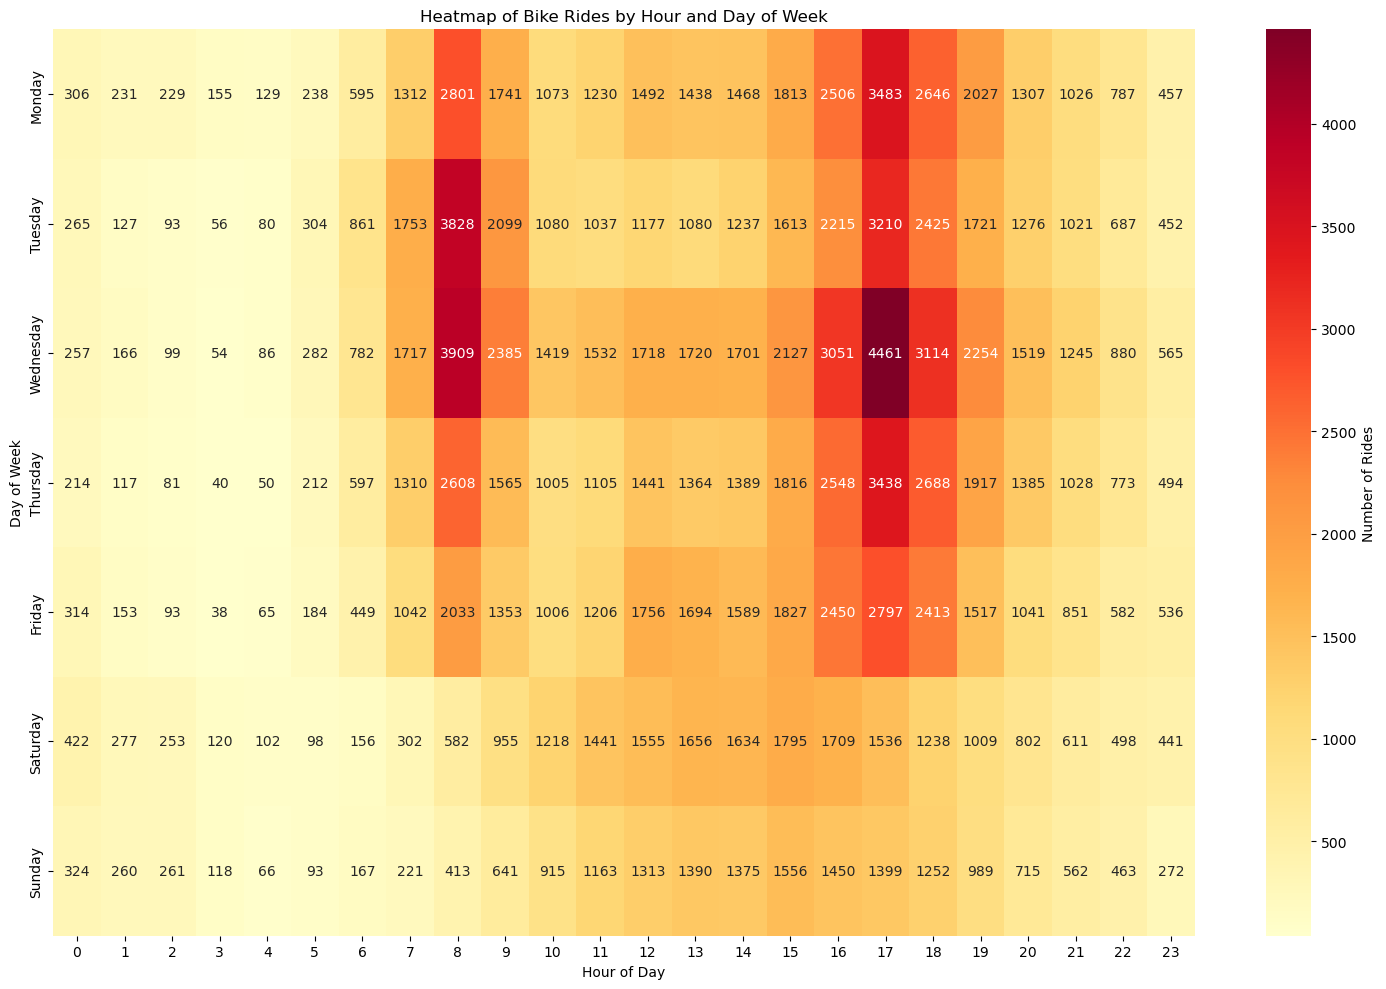

Busiest day and hour combinations:
Wednesday at 17:00 - 4461 rides
Wednesday at 08:00 - 3909 rides
Tuesday at 08:00 - 3828 rides
Monday at 17:00 - 3483 rides
Thursday at 17:00 - 3438 rides

Least busy day and hour combinations:
Friday at 03:00 - 38 rides
Thursday at 03:00 - 40 rides
Thursday at 04:00 - 50 rides
Wednesday at 03:00 - 54 rides
Tuesday at 03:00 - 56 rides

Average number of rides by day of week:
Wednesday: 1543.46
Monday: 1270.42
Tuesday: 1237.38
Thursday: 1216.04
Friday: 1124.54
Saturday: 850.42
Sunday: 724.08

Top 5 busiest hours (average across all days):
17:00 - 2903.43
08:00 - 2310.57
16:00 - 2275.57
18:00 - 2253.71
15:00 - 1792.43


In [17]:
# Convert 'Start Time' to datetime
df['Start Time'] = pd.to_datetime(df['Start Time'])

# Extract hour and day of week
df['Hour'] = df['Start Time'].dt.hour
df['Day of Week'] = df['Start Time'].dt.day_name()

# Create a pivot table for the heatmap
heatmap_data = df.groupby(['Day of Week', 'Hour']).size().unstack()

# Reorder the days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(day_order)

# Create the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='g', cbar_kws={'label': 'Number of Rides'})

plt.title('Heatmap of Bike Rides by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

# Calculate and display some statistics
print("Busiest day and hour combinations:")
busiest_times = heatmap_data.stack().nlargest(5)
for (day, hour), count in busiest_times.items():
    print(f"{day} at {hour:02d}:00 - {count} rides")

print("\nLeast busy day and hour combinations:")
least_busy_times = heatmap_data.stack().nsmallest(5)
for (day, hour), count in least_busy_times.items():
    print(f"{day} at {hour:02d}:00 - {count} rides")

# Calculate average number of rides by day of week
avg_by_day = heatmap_data.mean(axis=1).sort_values(ascending=False)
print("\nAverage number of rides by day of week:")
for day, avg in avg_by_day.items():
    print(f"{day}: {avg:.2f}")

# Calculate average number of rides by hour
avg_by_hour = heatmap_data.mean(axis=0).sort_values(ascending=False)
print("\nTop 5 busiest hours (average across all days):")
for hour, avg in avg_by_hour.head().items():
    print(f"{hour:02d}:00 - {avg:.2f}")

## Station Pair Analysis and Trip Patterns <a id="7"></a>

An in-depth analysis of station pairs and trip patterns was conducted to uncover key insights about the Toronto bike-sharing system's usage.

### 1. Station Pair Frequency Analysis
- The frequency of trips between each unique pair of stations was calculated.
- Average trip duration for each station pair was computed.
- The top 10 most frequent station pairs were identified and displayed.

### 2. Visualization of Popular Routes
- A bar plot was created to visualize the top 20 most frequent station pairs, providing a clear view of the most popular routes in the system.

### 3. Frequency vs. Duration Analysis
- A scatter plot was generated to explore the relationship between trip frequency and average duration for station pairs.
- Log scales were used for both axes to better visualize the distribution across a wide range of values.

### 4. Busiest Start Stations
- The top 10 busiest stations as starting points for trips were identified and visualized using a bar plot.

### 5. Additional Insights
Several key statistics were calculated to provide a comprehensive overview of the system:
- Total number of trips in the dataset
- Number of unique station pairs
- Average and median trip durations
- Most common station pair
- Longest and shortest average trip durations between station pairs


Top 10 Most Frequent Station Pairs:
                                                    Frequency  \
Station Pair                                                    
Front St W / Blue Jays Way to Union Station               158   
111 Bond St (North of Dundas St E)  - SMART to ...        106   
Gould St / Mutual St to 111 Bond St (North of D...         94   
St. George St / Bloor St W to St. George St / R...         86   
King St W / Portland St - SMART to King St W / ...         83   
King St W / Charlotte St (West Side) to King St...         75   
Fort York  Blvd / Capreol Ct to Union Station              73   
Bay St / College St (East Side) to College St /...         68   
College St / Huron St to Bay St / College St (E...         68   
St. George St / Russell St - SMART to St. Georg...         66   

                                                    Avg Duration (seconds)  
Station Pair                                                                
Front St W / Blue Jays Way to

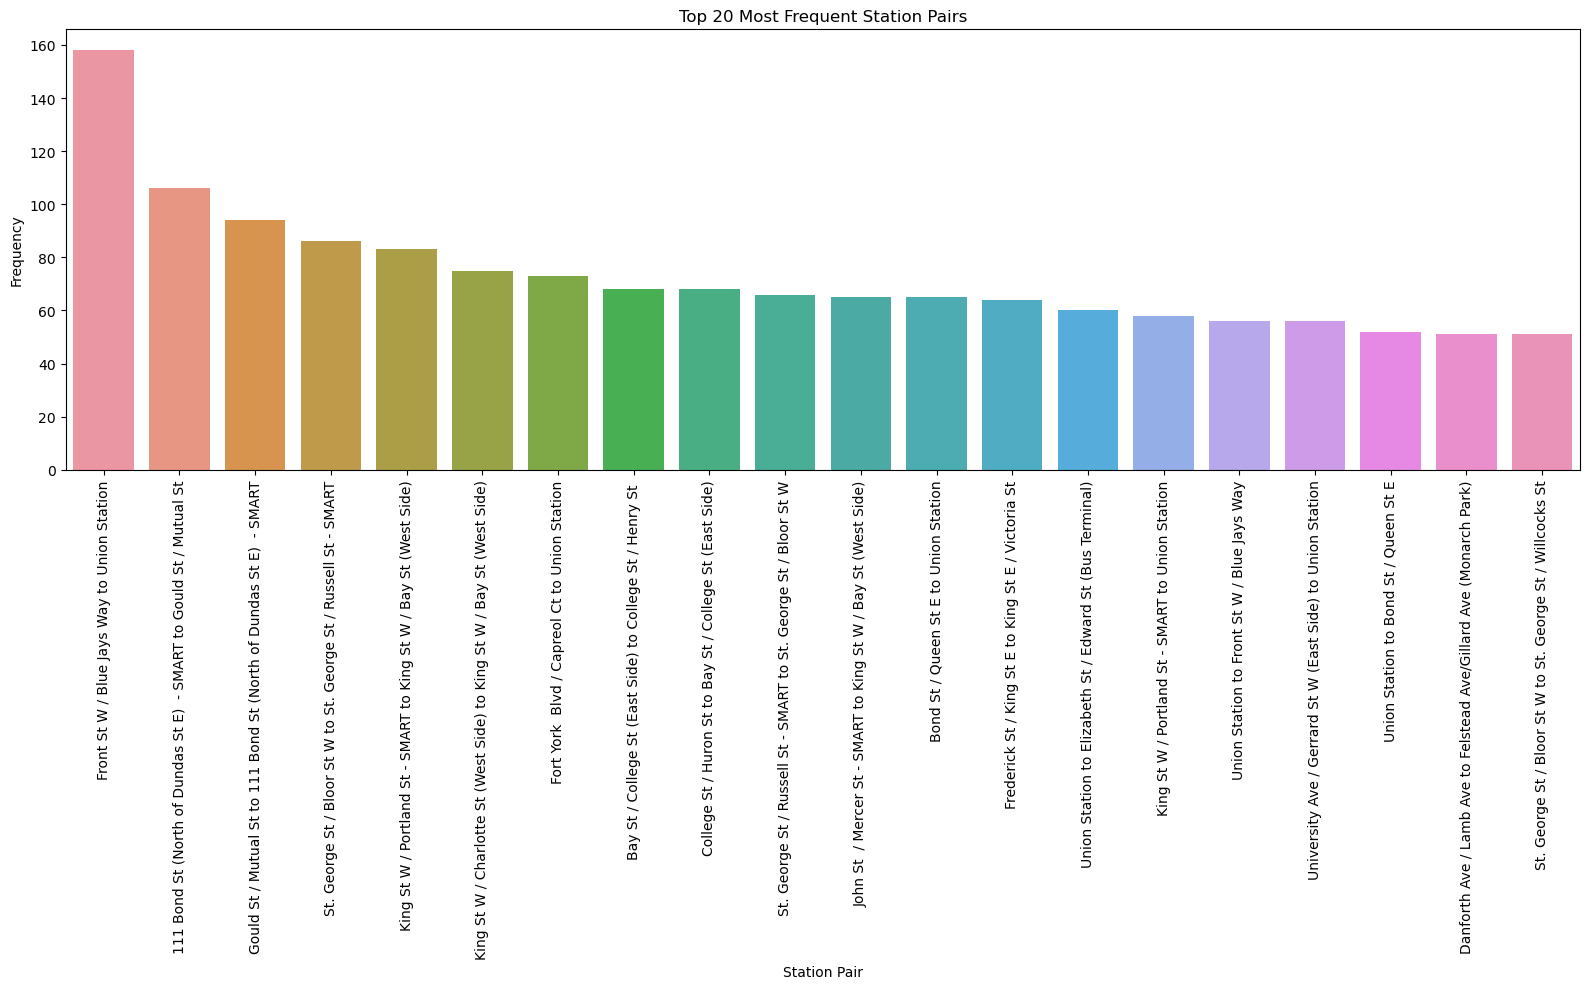

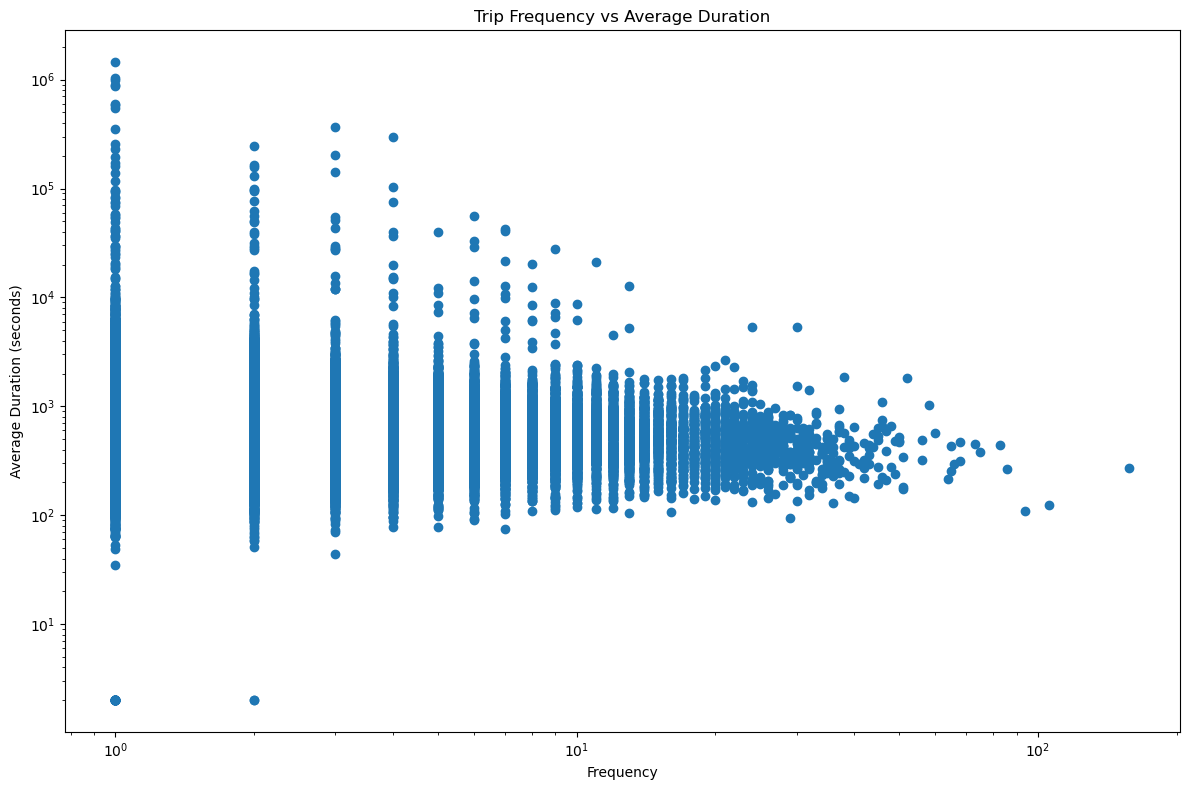

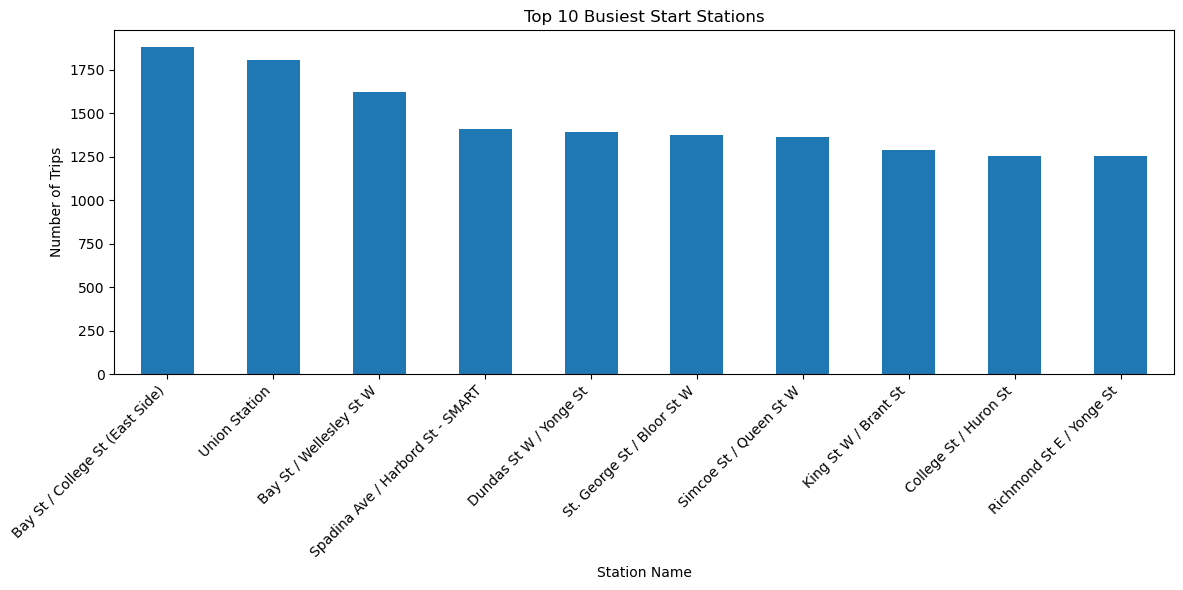

Analysis complete. Plots have been displayed.

Additional Insights:
Total number of trips: 191192
Number of unique station pairs: 63440
Average trip duration: 14.44 minutes
Median trip duration: 9.53 minutes
Most common station pair: Front St W / Blue Jays Way to Union Station
Longest average trip duration: 24066.83 minutes
Shortest average trip duration: 0.03 minutes


In [18]:
# Count the frequency of each station pair
station_pair_counts = df['Station Pair'].value_counts()

# Calculate average trip duration for each station pair
station_pair_durations = df.groupby('Station Pair')['Trip  Duration'].mean()

# Combine frequency and duration data
station_pair_data = pd.DataFrame({
    'Frequency': station_pair_counts,
    'Avg Duration (seconds)': station_pair_durations
})

# Sort by frequency
station_pair_data = station_pair_data.sort_values('Frequency', ascending=False)

# Print top 10 most frequent station pairs
print("Top 10 Most Frequent Station Pairs:")
print(station_pair_data.head(10))

# Visualize top 20 most frequent station pairs
plt.figure(figsize=(16, 10))
sns.barplot(x=station_pair_data.head(20).index, y='Frequency', data=station_pair_data.head(20))
plt.title('Top 20 Most Frequent Station Pairs')
plt.xlabel('Station Pair')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Scatter plot of frequency vs average duration
plt.figure(figsize=(12, 8))
plt.scatter(station_pair_data['Frequency'], station_pair_data['Avg Duration (seconds)'])
plt.title('Trip Frequency vs Average Duration')
plt.xlabel('Frequency')
plt.ylabel('Average Duration (seconds)')
plt.xscale('log')  # Use log scale for better visualization
plt.yscale('log')
plt.tight_layout()
plt.show()


# Top 10 stations as start points
top_start_stations = df['Start Station Name'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_start_stations.plot(kind='bar')
plt.title('Top 10 Busiest Start Stations')
plt.xlabel('Station Name')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Analysis complete. Plots have been displayed.")

# Additional insights
print("\nAdditional Insights:")
print(f"Total number of trips: {len(df)}")
print(f"Number of unique station pairs: {station_pair_data.shape[0]}")
print(f"Average trip duration: {df['Trip  Duration'].mean() / 60:.2f} minutes")
print(f"Median trip duration: {df['Trip  Duration'].median() / 60:.2f} minutes")
print(f"Most common station pair: {station_pair_data.index[0]}")
print(f"Longest average trip duration: {station_pair_data['Avg Duration (seconds)'].max() / 60:.2f} minutes")
print(f"Shortest average trip duration: {station_pair_data['Avg Duration (seconds)'].min() / 60:.2f} minutes")